In [2]:
from config import nodes_info
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from helper import first_peak
import matplotlib
from scipy.signal import find_peaks
from helper import load_txt_to_datetime, seg_index, datetime_from_str, color_scale, seg_index_new, load_segment_file_to_datetime_new
from export_data_from_influxDB.load_data_from_csv import load_csv, load_csv_new
from config import nodes_info
import subprocess
from datetime import timedelta, timezone

In [ ]:
# load _timestamp.txt file, check the start and end time of the data
def load_timestamp_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        start_time = datetime_from_str(lines[0].strip())
        end_time = datetime_from_str(lines[-1].strip())
    return start_time, end_time

path = "ADL_data/SB-50274X"
for file in path:
    if file.endswith("_timestamp.txt"):
        start_time, end_time = load_timestamp_file(os.path.join(path, file))
        print(start_time, end_time)

In [ ]:
import os
path = "ADL_data/SB-09565T"
for file in os.listdir(path):
    if file.endswith(".csv"):
        print(file)
        load_csv_new(path, file)
        # remove .csv
        os.remove(path + "/" + file)
        print(f"{path}/{file} removed.")
        break
    

e4-5f-01-8b-2d-e2.csv
['', 'result', 'table', '_start', '_stop', '_time', '_value', '_field', '_measurement', 'node_ID', 'patient_class', 'patient_id', 'session_id']
empty row
ADL_data/SB-46951W-2/e4-5f-01-8b-2d-e2.csv removed.
e4-5f-01-8b-1b-b1.csv
['', 'result', 'table', '_start', '_stop', '_time', '_value', '_field', '_measurement', 'node_ID', 'patient_class', 'patient_id', 'session_id']
empty row
ADL_data/SB-46951W-2/e4-5f-01-8b-1b-b1.csv removed.
e4-5f-01-8a-df-32.csv
['', 'result', 'table', '_start', '_stop', '_time', '_value', '_field', '_measurement', 'node_ID', 'patient_class', 'patient_id', 'session_id']
empty row
ADL_data/SB-46951W-2/e4-5f-01-8a-df-32.csv removed.
e4-5f-01-88-59-21.csv
['', 'result', 'table', '_start', '_stop', '_time', '_value', '_field', '_measurement', 'node_ID', 'patient_class', 'patient_id', 'session_id']
empty row
ADL_data/SB-46951W-2/e4-5f-01-88-59-21.csv removed.
e4-5f-01-8a-46-81.csv
['', 'result', 'table', '_start', '_stop', '_time', '_value', '_fi

### load data

In [3]:
def load_data(session_path, node_index):
    node_id = nodes_info[node_index]["id"]
    # left, right = nodes_info[node_index]["range"]
    filename = f"{node_id}.csv"
    
    complex_file = os.path.join(session_path, node_id + '_complex.npy')
    ts_uwb_file = os.path.join(session_path, node_id + '_timestamp.txt')

    if not os.path.exists(complex_file):
        load_csv_new(session_path, filename)
    data_complex = np.load(complex_file)
    dt = load_txt_to_datetime("", ts_uwb_file)    # load timestamp of each data frame
    return data_complex, dt

In [4]:
def compute_velocity_for_one_frame(range_doppler=np.random.rand(32, 188)):
    """
    get the peak columns in one range doppler frame, return the mean value of the peak columns, which is the velocity distribution.
    Assumption here is, during the time of the frame, the object is moving within 20cm, so we use left 2 columns and right 2 columns of the peak column to calculate the sum.

    range_doppler_window: 2-d array, shape (32, 188), the range doppler window of one frame.
    return: 1-d array, shape (32, ), the sum of the peak columns in one range doppler frame.

    """
    doppler_bin_num, range_bin_num = range_doppler.shape
    # range_doppler[14:18, :] = np.zeros((4, range_bin_num))
    
    # d-fft: x is distance, y is velocity, value is intensity.
    # the peak value is the intensity at the particular velocity and distance.
    # find the peak value in 2-d d_fft and its index (v, d) in d_fft, then use the left 2 columns and right columns, 5 columns in total to calculate the sum along x-axis
    # the index is the velocity and distance
    # the mean is the intensity among the 5 columns
    peak = np.max(range_doppler)
    v, d = np.where(range_doppler == peak)
    v, d = v[0], d[0]
    left = d-2 if d-2 >= 0 else 0
    right = d+3 if d+3 < range_bin_num else range_bin_num-1
    return np.sum(range_doppler[:, left:right], axis=1), v, d, peak

In [5]:
def compute_distance_for_one_frame(range_doppler=np.random.rand(32, 188)):
    """
    get the peak columns in one range doppler frame, return the mean value of the peak columns, which is the velocity distribution.
    Assumption here is, during the time of the frame, the object is moving within 20cm, so we use left 2 columns and right 2 columns of the peak column to calculate the sum.

    range_doppler_window: 2-d array, shape (32, 188), the range doppler window of one frame.
    return: 1-d array, shape (32, ), the sum of the peak columns in one range doppler frame.

    """
    doppler_bin_num, range_bin_num = range_doppler.shape
    # range_doppler[14:18, :] = np.zeros((4, range_bin_num))
    
    # d-fft: x is distance, y is velocity, value is intensity.
    # the peak value is the intensity at the particular velocity and distance.
    # find the peak value in 2-d d_fft and its index (v, d) in d_fft, then use the left 2 columns and right columns, 5 columns in total to calculate the sum along x-axis
    # the index is the velocity and distance
    # the mean is the intensity among the 5 columns
    peak = np.max(range_doppler)
    v, d = np.where(range_doppler == peak)
    v, d = v[0], d[0]
    up = v-2 if v-2 >= 0 else 0
    bottom = v+3 if v+3 < doppler_bin_num else doppler_bin_num-1
    return np.sum(range_doppler[up:bottom, :], axis=0), v, d, peak


In [6]:
def compute_feature_for_one_frame(range_doppler=np.random.rand(32, 188)):
    """
    get the peak columns in one range doppler frame, return the mean value of the peak columns, which is the velocity distribution.
    Assumption here is, during the time of the frame, the object is moving within 20cm, so we use left 2 columns and right 2 columns of the peak column to calculate the sum.

    range_doppler_window: 2-d array, shape (32, 188), the range doppler window of one frame.
    return: 1-d array, shape (32, ), the sum of the peak columns in one range doppler frame; 1-d array, shape (188, ), the sum of the peak rows in one range doppler frame.

    """
    doppler_bin_num, range_bin_num = range_doppler.shape
    range_doppler[14:18, :] = np.zeros((4, range_bin_num))
    
    # d-fft: x is distance, y is velocity, value is intensity.
    # the peak value is the intensity at the particular velocity and distance.
    # find the peak value in 2-d d_fft and its index (v, d) in d_fft, then use the left 2 columns and right columns, 5 columns in total to calculate the sum along x-axis
    # the index is the velocity and distance
    # the mean is the intensity among the 5 columns
    peak = np.max(range_doppler)
    v, d = np.where(range_doppler == peak)
    v, d = v[0], d[0]
    up = v-2 if v-2 >= 0 else 0
    bottom = v+3 if v+3 < doppler_bin_num else doppler_bin_num-1

    left = d-2 if d-2 >= 0 else 0
    right = d+3 if d+3 < range_bin_num else range_bin_num-1
    return np.sum(range_doppler[up:bottom, :], axis=0), np.sum(range_doppler[:, left:right], axis=1), v, d, peak

In [7]:
def computer_velocity_over_time(data_complex, doppler_bin_num=32, step=5, range_bin_num=188):
    """
    For each data window (2-d, (time, range_bin_num)), compute the range doppler using sliding window and FFT. window siez is 32, step is 5. 
        -> Get all range doppler frames (3-d, (time, doppler_bin_num, range_bin_num)).
    For each range doppler frame (2-d, (doppler_bin_num, range_bin_num)), compute the velocity distribution (1-d, (doppler_bin_num, )).
    Concatenate the velocity distribution of each frame to get the velocity distribution over time (2-d, (time, doppler_bin_num)).
    
    input: data_complex: 2-d array, shape (time, range_bin_num), the complex data of the radar.
    output: velocity: 2-d array, shape (time, doppler_bin_num), the velocity distribution over time.
    """
    frame_num = (data_complex.shape[0] - 32) // step + 1
    range_doppler = np.zeros((frame_num, doppler_bin_num, range_bin_num))
    # velocity = np.zeros((frame_num, doppler_bin_num))
    for i in range(0, data_complex.shape[0] - 32, step):
        range_doppler[i//5] = np.abs(np.fft.fft(data_complex[i:i+doppler_bin_num, :], axis=0))  # FFT
        range_doppler[i//5] = np.fft.fftshift(range_doppler[i//5], axes=0)  # shifts

        range_doppler[i//5, 14:18, :] = np.zeros((4, range_bin_num))
    velocity = np.array([compute_velocity_for_one_frame(range_doppler[i, :, :]) for i in range(frame_num)])
    return velocity

In [8]:
def computer_features_over_time(data_complex, doppler_bin_num=32, step=5, range_bin_num=188):
    """
    For each data window (2-d, (time, range_bin_num)), compute the range doppler using sliding window and FFT. window siez is 32, step is 5. 
        -> Get all range doppler frames (3-d, (time, doppler_bin_num, range_bin_num)).
    For each range doppler frame (2-d, (doppler_bin_num, range_bin_num)), compute the velocity distribution (1-d, (doppler_bin_num, )).
    Concatenate the velocity distribution of each frame to get the velocity distribution over time (2-d, (time, doppler_bin_num)).
    
    input: data_complex: 2-d array, shape (time, range_bin_num), the complex data of the radar.
    output: 
        velocity: 2-d array, shape (time, doppler_bin_num), the velocity distribution over time.
        distance: 2-d array, shape (time, range_bin_num), the distance distribution over time.
    """
    frame_num = (data_complex.shape[0] - 32) // step + 1
    range_doppler = np.zeros((frame_num, doppler_bin_num, range_bin_num))
    # velocity = np.zeros((frame_num, doppler_bin_num))
    for i in range(0, data_complex.shape[0] - 32, step):
        range_doppler[i//5] = np.abs(np.fft.fft(data_complex[i:i+doppler_bin_num, :], axis=0))  # FFT
        range_doppler[i//5] = np.fft.fftshift(range_doppler[i//5], axes=0)  # shifts
        range_doppler[i//5, 14:18, :] = np.zeros((4, range_bin_num))

    velocity = np.array([compute_velocity_for_one_frame(range_doppler[i, :, :])[0] for i in range(frame_num)])
    distance = np.array([compute_distance_for_one_frame(range_doppler[i, :, :])[0] for i in range(frame_num)])

    return velocity, distance

In [19]:
os.chdir("/home/mengjingliu/ADL_unsupervised_learning")

data_complex, dt = load_data("ADL_data/8F33UK", 7)
indices, acts = seg_index_new(dt, "ADL_data/2023-07-03-segment/2024-10-15-17-22-48_8F33UK.txt")
velocities = []
distances = []
for i in range(14, 35):
    start, end = indices[i]
    print(acts[i])
    velocity, distance = computer_features_over_time(data_complex[start:end, :], doppler_bin_num=32, step=5, range_bin_num=188)
    velocities.append(velocity)
    distances.append(distance)

not formative line in segment file:  stop: 2024-10-15 17:54:18.867

activity 38, stop: 2024-10-15 17:54:18.867 is lost
Shower simulation
Brush teeth
Wash face
Simulate using toilet
Washing hands
Review next set of activities
Walk to the bedroom
Hang towel in cabinet
Get another towel
Fold and place it in the cabinet
Remove shoes
Put on the Masimo Device
Lie down on the bed facing the ceiling
Lie down on the bed on your side
Lie down on the bed on your stomach
Get up and stay seated
Remove the device and wear your shoes
Walk to the desk outside bedroom
Put on Masimo device
Retype the phrase on the laptop
Remove the Masimo device


Shower simulation


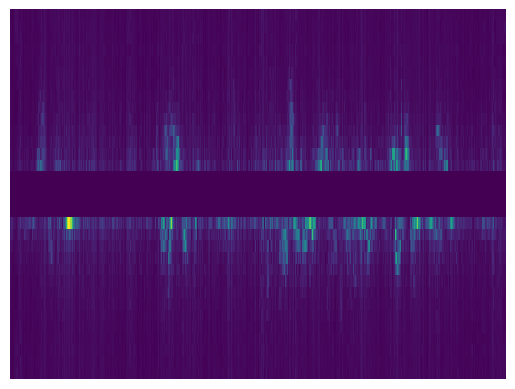

Brush teeth


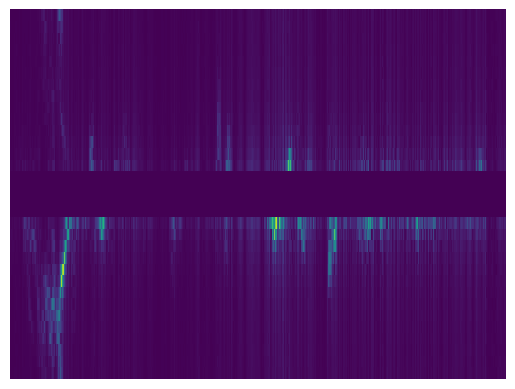

Wash face


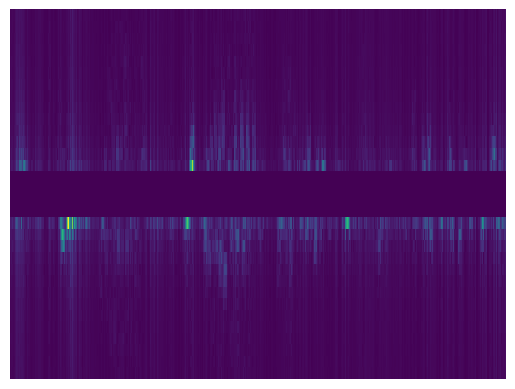

Simulate using toilet


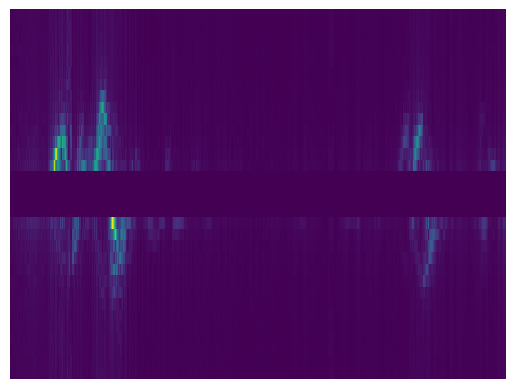

Washing hands


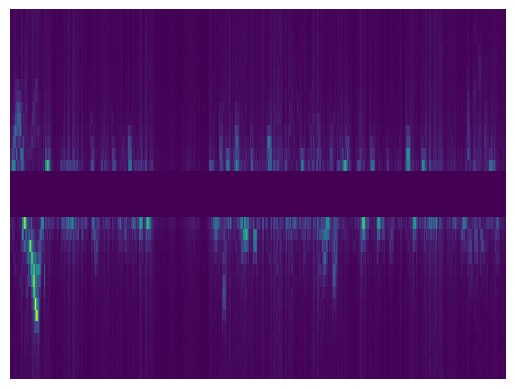

Review next set of activities


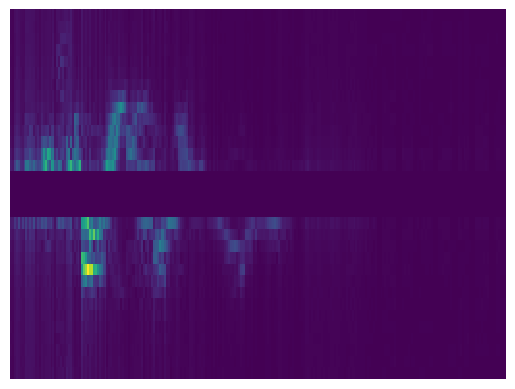

Walk to the bedroom


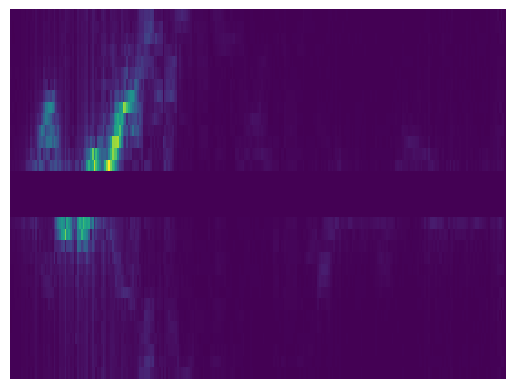

Hang towel in cabinet


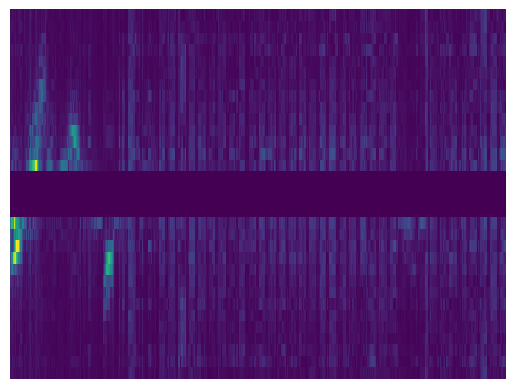

Get another towel


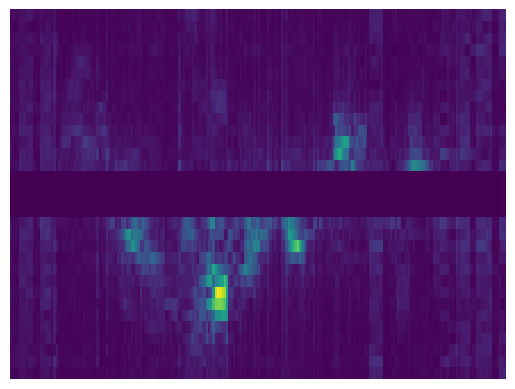

Fold and place it in the cabinet


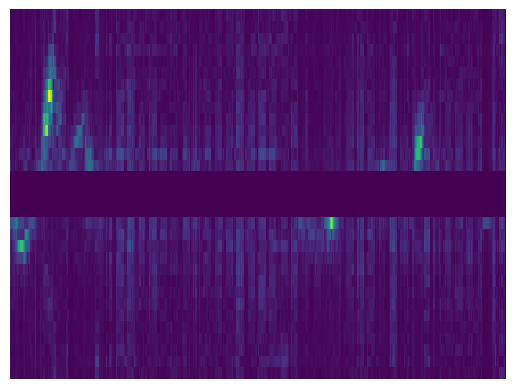

Remove shoes


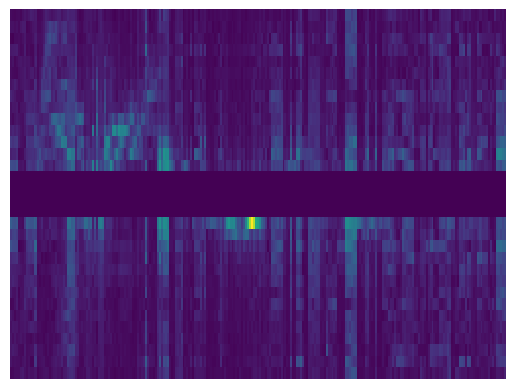

Put on the Masimo Device


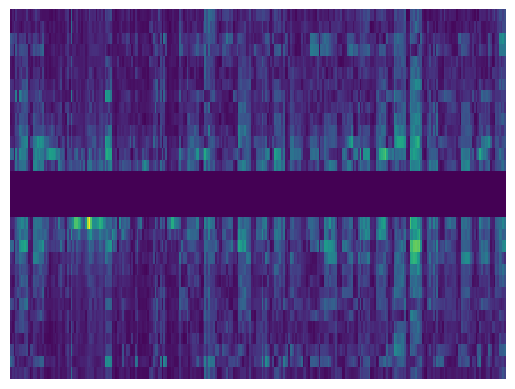

Lie down on the bed facing the ceiling


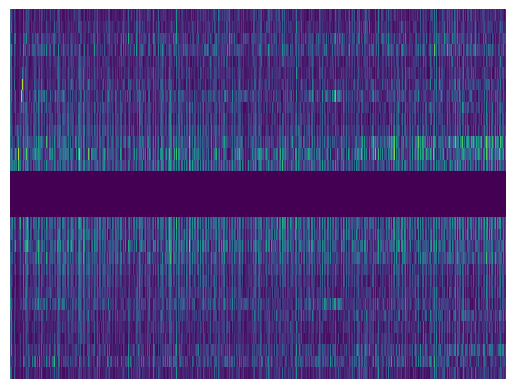

Lie down on the bed on your side


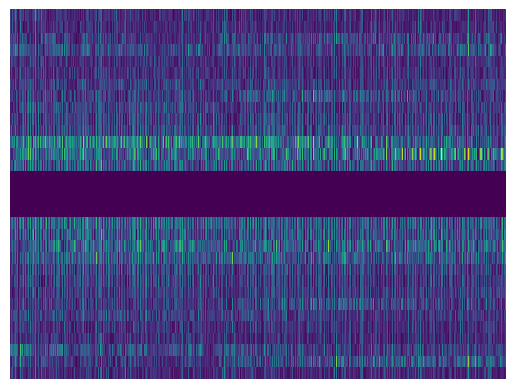

Lie down on the bed on your stomach


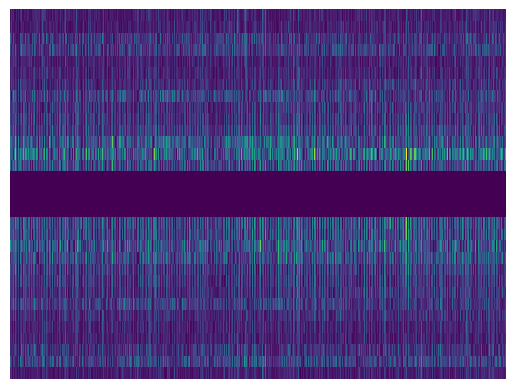

Get up and stay seated


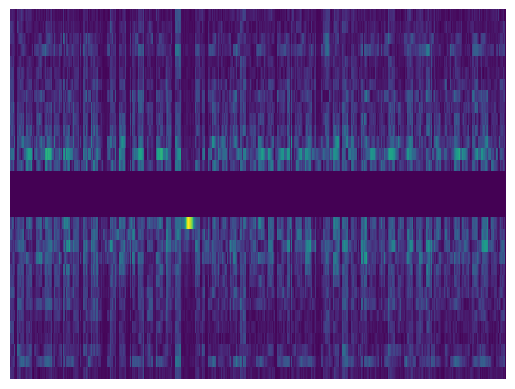

Remove the device and wear your shoes


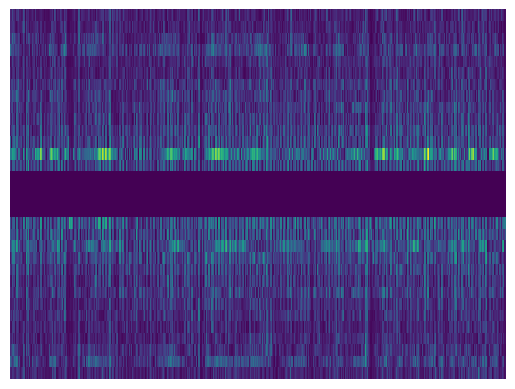

Walk to the desk outside bedroom


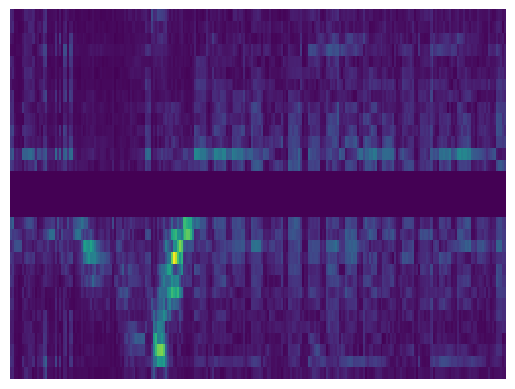

Put on Masimo device


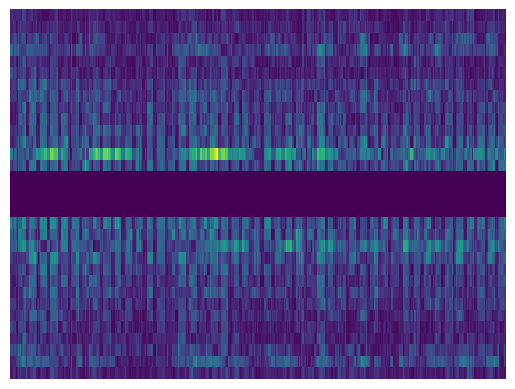

Retype the phrase on the laptop


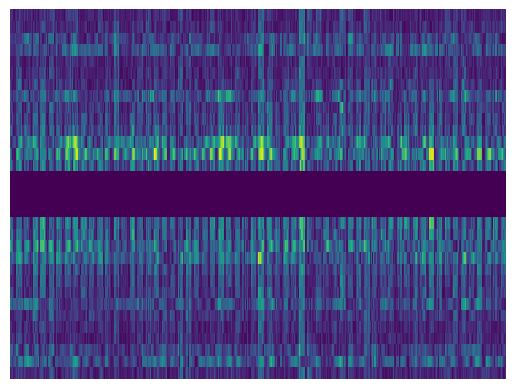

Remove the Masimo device


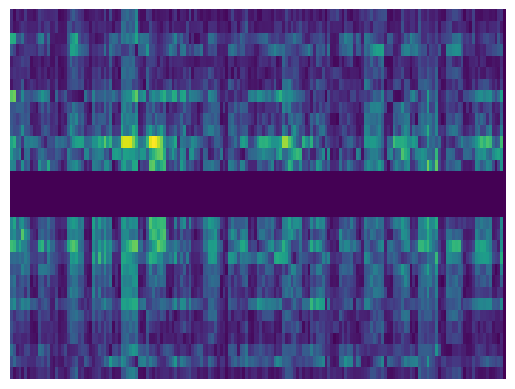

In [20]:
# velocities is a list of 2-d array, with differnet shapes. normalize the values to 0~1
min_v = min([np.min(velocity) for velocity in velocities])
max_v = max([np.max(velocity) for velocity in velocities])
i = 14
for v in velocities:
    print(acts[i])
    i += 1
    v = (v - min_v) / (max_v - min_v)   # normalize the values to 0~1
    sns.heatmap(v.T, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    plt.show()

Shower simulation


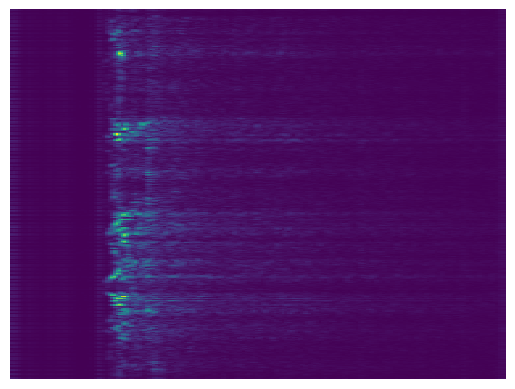

Brush teeth


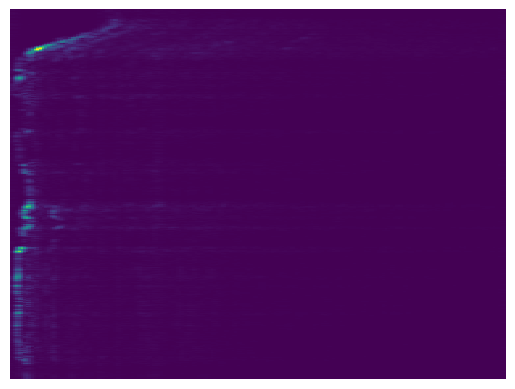

Wash face


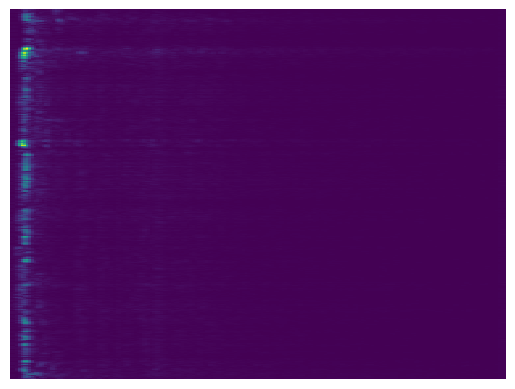

Simulate using toilet


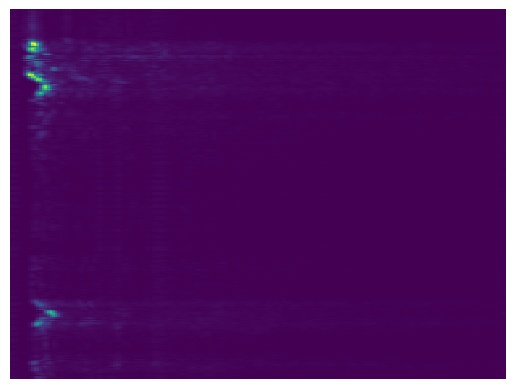

Washing hands


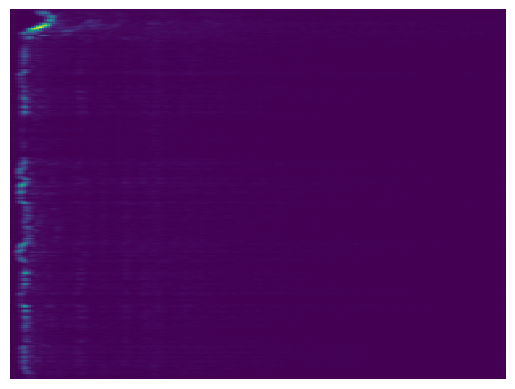

Review next set of activities


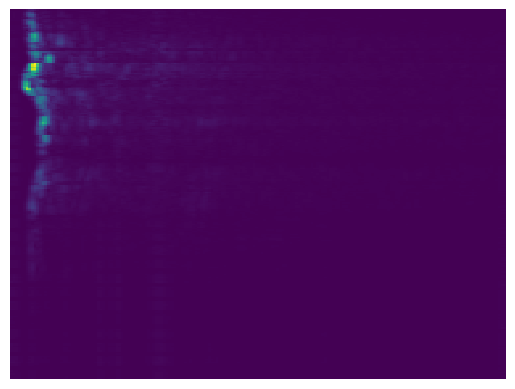

Walk to the bedroom


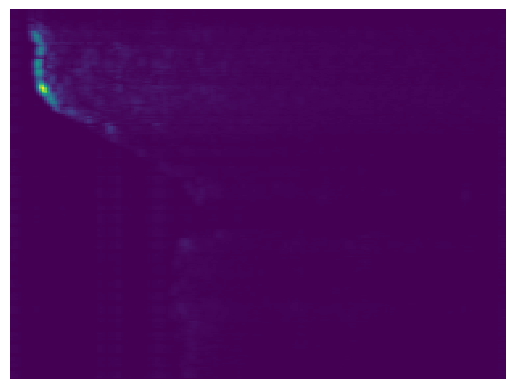

Hang towel in cabinet


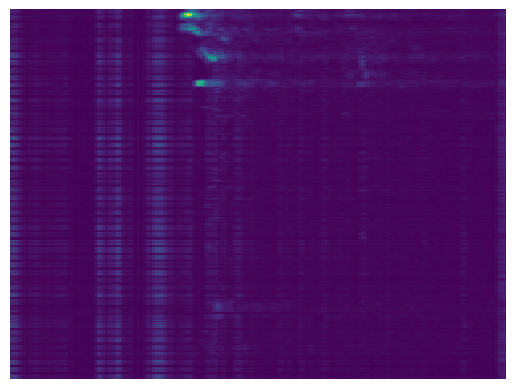

Get another towel


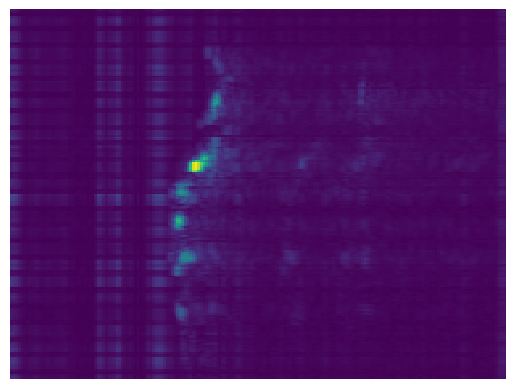

Fold and place it in the cabinet


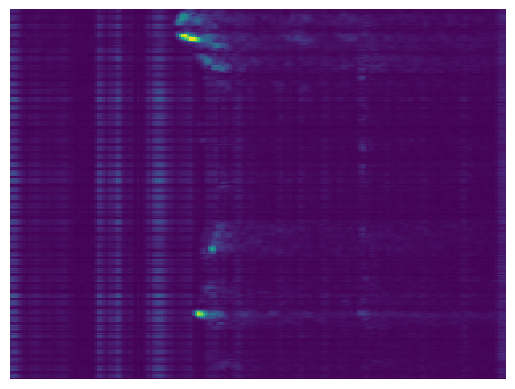

In [18]:
# distance is a list of 2-d array, with differnet shapes. normalize the values to 0~1
min_d = min([np.min(distance) for velocity in distances])
max_d = max([np.max(distance) for velocity in distances])
i = 14
for d in distances:
    print(acts[i])
    i += 1
    d = (d - min_d) / (max_d - min_d)   # normalize the values to 0~1
    sns.heatmap(d, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    plt.show()